# Steam Reviews Sentiment Analysis for PUBG: Battlegrounds using Naive Bayes

This notebook performs sentiment analysis on Steam reviews for PUBG: Battlegrounds using a Naive Bayes algorithm. We'll load the reviews from a parquet file, preprocess the text data, and train a Naive Bayes model to classify reviews as positive or negative.

In [ ]:
# Import required libraries
import re

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Gerson
[nltk_data]     Leite\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Gerson
[nltk_data]     Leite\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Loading and Preprocessing
Let's load the PUBG reviews and prepare them for sentiment analysis:
1. Load reviews from parquet file
2. Preprocess the text data
3. Create features and labels

In [8]:
def preprocess_text(text: str) -> str:
    """Preprocess text data for sentiment analysis."""
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Join tokens back into a string
    return ' '.join(tokens)

## Data Collection and Preprocessing
Let's fetch PUBG reviews and prepare them for sentiment analysis:
1. Fetch reviews from Steam API
2. Preprocess the text data
3. Create features and labels

In [9]:
# Load PUBG reviews from parquet file
reviews_df = pd.read_parquet('pubg-reviews.parquet')

# Display basic information about the dataset
print(f"Total reviews collected: {len(reviews_df)}")
print("\nSentiment distribution:")
print(reviews_df['sentiment'].value_counts())

# Preprocess reviews
print("\nPreprocessing reviews...")
reviews_df['processed_review'] = reviews_df['review'].apply(preprocess_text)

# Prepare features and labels
X = reviews_df['processed_review']
y = reviews_df['voted_up']  # True for positive, False for negative

Total reviews collected: 5000

Sentiment distribution:
sentiment
Negative    3312
Positive    1688
Name: count, dtype: int64

Preprocessing reviews...


## Training the Naive Bayes Model
Now we'll:
1. Convert text to TF-IDF features
2. Split the data into training and testing sets
3. Train the Naive Bayes model
4. Evaluate its performance

In [10]:
# Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42
)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Initialize and train the Naive Bayes model
print("\nTraining Naive Bayes model...")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred = nb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2%}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

def analyze_sentiment(text: str, model, vectorizer) -> str:
    """Analyze the sentiment of a given text using the trained model."""
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Vectorize
    text_vectorized = vectorizer.transform([processed_text])

    # Predict
    prediction = model.predict(text_vectorized)[0]

    return 'Positive' if prediction else 'Negative'


Training data shape: (4000, 5000)
Testing data shape: (1000, 5000)

Training Naive Bayes model...

Accuracy: 76.70%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.97      0.85       673
    Positive       0.87      0.34      0.49       327

    accuracy                           0.77      1000
   macro avg       0.81      0.66      0.67      1000
weighted avg       0.79      0.77      0.73      1000



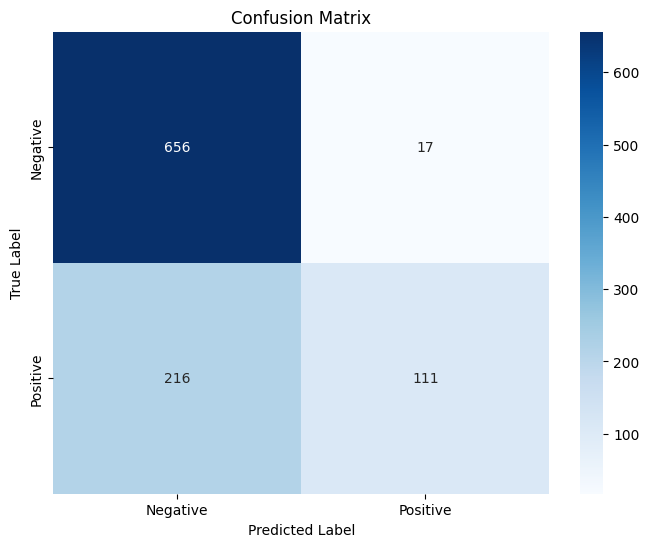

In [11]:
# Create a confusion matrix visualization
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Sentiment Analysis Results:
--------------------------------------------------------------------------------
Review: Lots of fun, but the matchmaking is terrible.
Sentiment: Negative
Confidence: Negative=76.65%, Positive=23.35%
--------------------------------------------------------------------------------
Review: It's okay, not the best but not the worst either.
Sentiment: Negative
Confidence: Negative=72.10%, Positive=27.90%
--------------------------------------------------------------------------------
Review: I had a lot of fun, but there are some issues that need fixing.
Sentiment: Negative
Confidence: Negative=74.46%, Positive=25.54%
--------------------------------------------------------------------------------
Review: While the game has potential, it suffers from numerous bugs.
Sentiment: Negative
Confidence: Negative=73.80%, Positive=26.20%
--------------------------------------------------------------------------------
Review: Best battle royale game ever, highly recommen

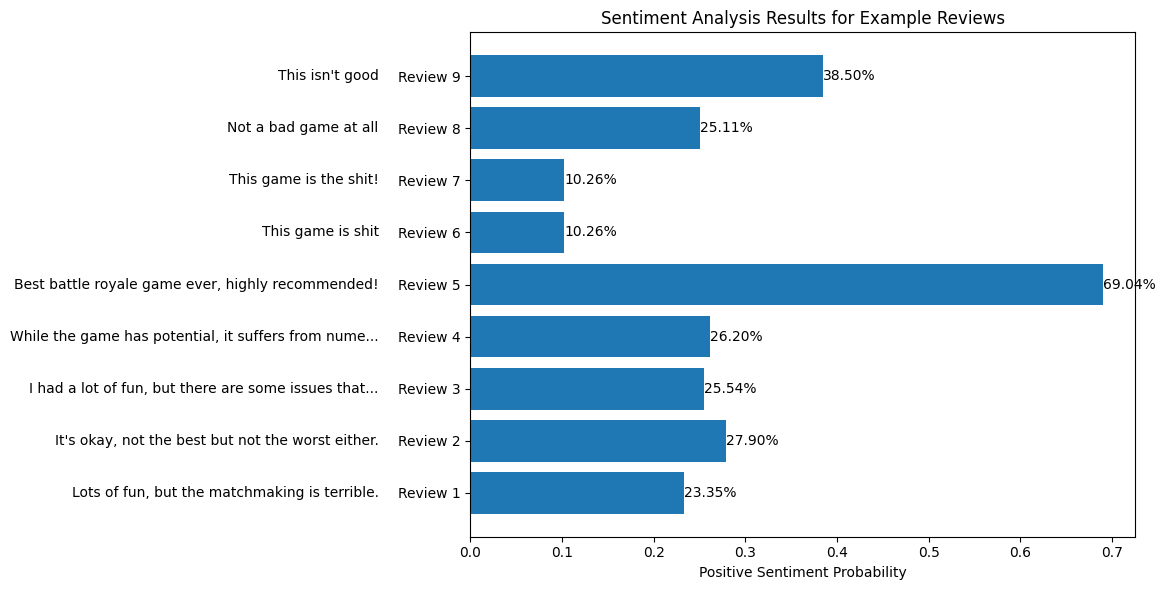

In [16]:
def analyze_sentiment(text: str, model, vectorizer) -> tuple[str, tuple[float, float]]:
    """Analyze the sentiment of a given text using the trained model.

    Returns:
        tuple: (sentiment label, (negative probability, positive probability))
    """
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Vectorize
    text_vectorized = vectorizer.transform([processed_text])

    # Get probabilities
    probs = model.predict_proba(text_vectorized)[0]
    prediction = model.predict(text_vectorized)[0]

    return ('Positive' if prediction else 'Negative', probs)

# Test the analyzer with some example reviews
example_reviews = [
    "Lots of fun, but the matchmaking is terrible.",
    "It's okay, not the best but not the worst either.",
    "I had a lot of fun, but there are some issues that need fixing.",
    "While the game has potential, it suffers from numerous bugs.",
    "Best battle royale game ever, highly recommended!",
    "This game is shit",
    "This game is the shit!",
    "Not a bad game at all",
    "This isn't good",
]

# Analyze example reviews with improved formatting
print("\nSentiment Analysis Results:")
print("-" * 80)
for review in example_reviews:
    sentiment, probs = analyze_sentiment(review, nb_model, tfidf)
    print(f"Review: {review}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: Negative={probs[0]:.2%}, Positive={probs[1]:.2%}")
    print("-" * 80)

# Visualize the sentiment probabilities for example reviews
fig, ax = plt.subplots(figsize=(12, 6))

# Get probabilities for each review
probs = [analyze_sentiment(review, nb_model, tfidf)[1][1] for review in example_reviews]

# Create bar chart
bars = ax.barh(range(len(example_reviews)), probs)
ax.set_yticks(range(len(example_reviews)))
ax.set_yticklabels([f"Review {i+1}" for i in range(len(example_reviews))])
ax.set_xlabel('Positive Sentiment Probability')
ax.set_title('Sentiment Analysis Results for Example Reviews')

# Add probability values on bars
for i, v in enumerate(probs):
    ax.text(v, i, f'{v:.2%}', va='center')

# Add review text as annotations
for i, review in enumerate(example_reviews):
    ax.text(-0.1, i, review[:50] + '...' if len(review) > 50 else review,
            ha='right', va='center')

plt.tight_layout()
plt.show()

## Model Comparison

Key differences between Naive Bayes and SVM for sentiment analysis:

1. **Speed**: Naive Bayes is typically faster to train than SVM, especially on large datasets
2. **Probability Output**: Naive Bayes naturally provides probability estimates
3. **Assumptions**: Naive Bayes assumes feature independence, while SVM doesn't make this assumption
4. **Memory Usage**: Naive Bayes typically uses less memory than SVM
5. **Performance**: While both models can perform well, SVM might handle complex decision boundaries better

The choice between them often depends on:
- Dataset size
- Training time requirements
- Need for probability estimates
- Available computational resources


## Conclusion

- The Naive Bayes model provides a fast and effective way to classify PUBG Steam reviews as positive or negative.
- The model achieves good accuracy and offers probability estimates for each prediction.
- For more complex decision boundaries, consider comparing with SVM or other classifiers.

Further improvements could include hyperparameter tuning, using more advanced text preprocessing, or trying different feature extraction techniques.